In [1]:
# # # TODO: The threshold of 0.5 is arbitrary and might need to be adjusted based on your specific dataset and the model you are using. For some models, even moderately correlated features might pose problems, while for others, even higher correlations might not be as concerning.
# # # TODO: As a baseline model we can also use a model that has built-in mechanisms for feature selection (like L1 regularization for linear models). 
# # # TODO: Saga: Not checking missing values, outliers, or other data quality issues, imbalanced dataset. These can also affect the model's performance and should be addressed before or during feature selection.

In [2]:
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from skl2onnx import convert_sklearn
from sklearn.preprocessing import StandardScaler
import pingouin as pg
# define a XGBoost classifier
import xgboost as xgb
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")  # Ignore runtime warnings
# Temporarily adjust pandas display settings for large DataFrames
pd.set_option('display.max_rows', 100)  # Ensure 100 rows can be displayed
pd.set_option('display.max_columns', None)  # Ensure all columns can be displayed
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Ensure full width of column content is shown
pd.set_option('display.float_format', '{:.4f}'.format)  # Format the float numbers for better readability


# Data preprocessing and feature selection

Our data consists of binary data so we only want to calculate the Z-score for non-binary colomns

In [3]:
# Load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

Before cleaning:
Missing values per column:
Total missing values: 0


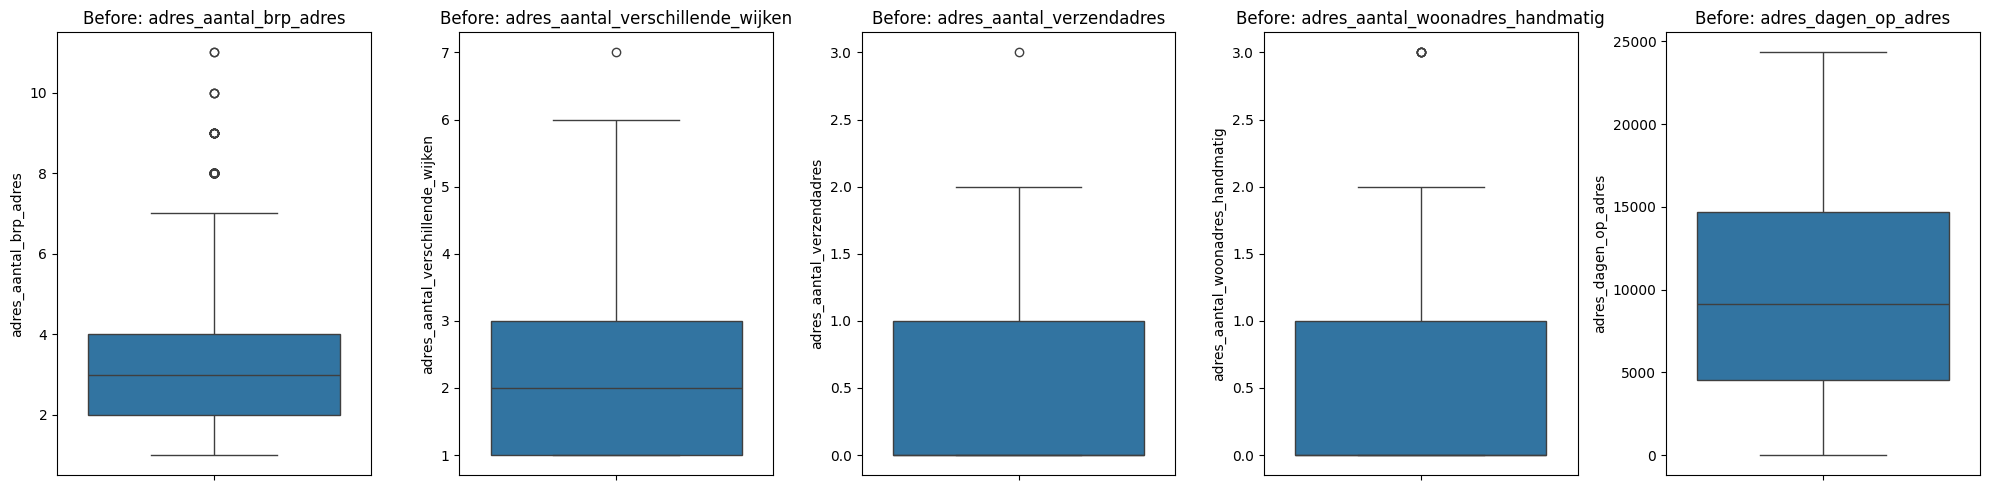

After cleaning:
Missing values per column:
Total missing values: 0


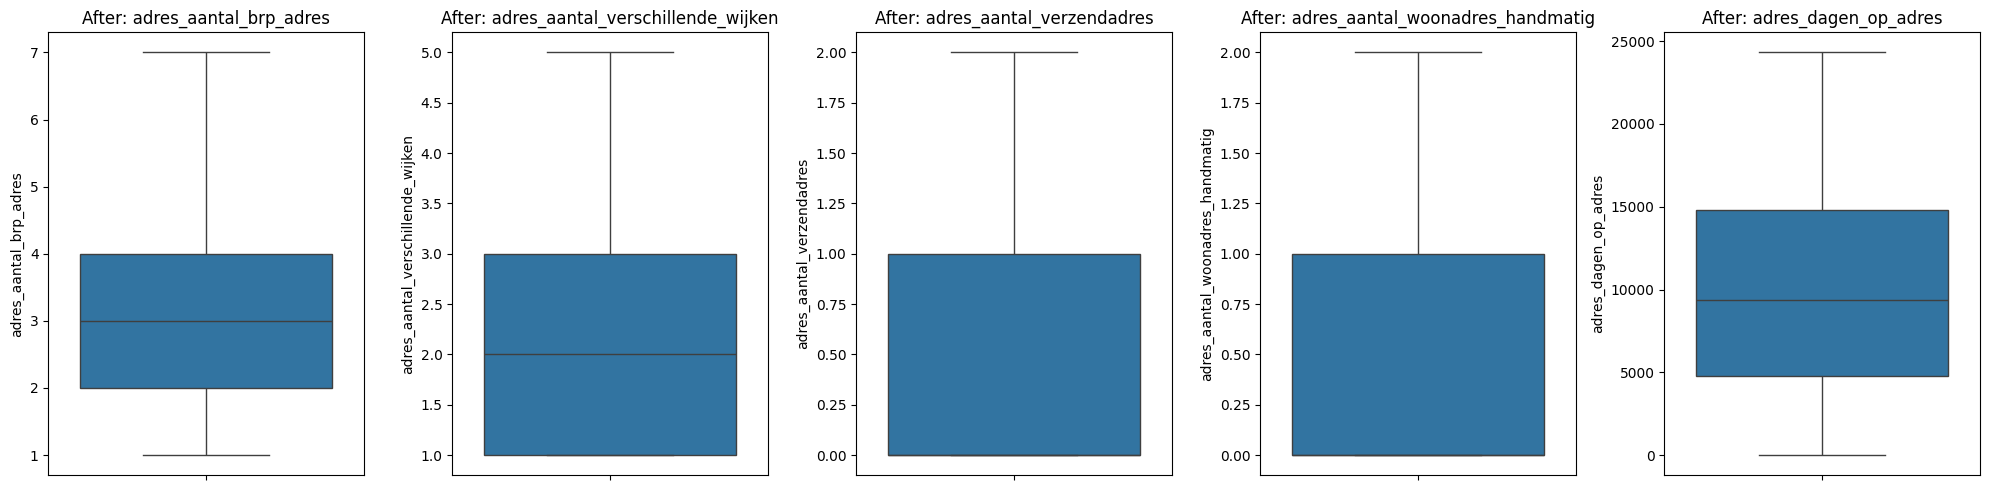

Shape before cleaning: (12645, 316)
Shape after cleaning: (10182, 316)


In [4]:


print("Before cleaning:")
print("Missing values per column:")
print("Total missing values:", data.isna().sum().sum())

# Identify non-binary columns
non_binary_columns = [col for col in data.columns if not (np.isin(data[col].unique(), [0, 1]).all() and len(data[col].unique()) == 2)]

# Calculate Z-scores for non-binary columns only
z_scores_non_binary = np.abs(stats.zscore(data[non_binary_columns], nan_policy='omit'))

# Mask to identify rows with outliers in non-binary columns
outlier_mask = (z_scores_non_binary > 3.5).any(axis=1)

# Select a subset of non-binary columns for plotting to avoid large image sizes
plot_columns = non_binary_columns[:5]  # Adjust this number based on your specific needs

# Plot outliers for the selected columns before removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data[col])
    plt.title(f'Before: {col}')
plt.tight_layout()
plt.show()

# Remove outliers from the dataset using the previously defined full_outlier_mask
data_cleaned = data[~outlier_mask]

print("After cleaning:")
print("Missing values per column:")
print("Total missing values:", data_cleaned.isna().sum().sum())

# Plot outliers for the selected columns after removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'After: {col}')
plt.tight_layout()
plt.show()

# Print the shape of the dataset before and after cleaning
print("Shape before cleaning:", data.shape)
print("Shape after cleaning:", data_cleaned.shape)

In [5]:
def calculate_correlation_matrix(data):
    return data.corr()

def identify_strong_correlations(corr_matrix, threshold=0.3):
    strong_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                strong_pairs.append((i, j, corr_value))
    return strong_pairs

def evaluate_partial_correlation(data, corr_matrix, strong_pairs, partial_threshold=0.2):
    highly_correlated_pairs = []
    for i, j, corr_value in strong_pairs:
        for k in range(len(corr_matrix.columns)):
            if k != i and k != j:
                subset = data[[corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.columns[k]]].dropna()
                if subset.shape[0] >= 3:
                    partial_corr = pg.partial_corr(data, x=corr_matrix.columns[i], y=corr_matrix.columns[j], covar=corr_matrix.columns[k])
                    if abs(partial_corr['r'].values[0]) < partial_threshold:
                        highly_correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value, corr_matrix.columns[k]))
                        break
                else:
                    print(f"Skipping due to insufficient data: {corr_matrix.columns[i]}, {corr_matrix.columns[j]}, {corr_matrix.columns[k]}")
    return highly_correlated_pairs

def find_highly_correlated_pairs(data, corr_matrix, threshold=0.5, partial_threshold=0.5):
    strong_pairs = identify_strong_correlations(corr_matrix, threshold)
    highly_correlated_pairs = evaluate_partial_correlation(data, corr_matrix, strong_pairs, partial_threshold)
    return highly_correlated_pairs

def determine_features_to_remove(corr_matrix, highly_correlated_pairs):
    features_to_remove = set()
    for i, j, _, _ in highly_correlated_pairs:
        avg_corr_i = corr_matrix[i].abs().mean()
        avg_corr_j = corr_matrix[j].abs().mean()
        if avg_corr_i > avg_corr_j:
            features_to_remove.add(i)
        else:
            features_to_remove.add(j)
    return features_to_remove

def reduce_features_from_data(data, features_to_remove):
    return data.drop(columns=list(features_to_remove))

def main(data):
    corr_matrix = calculate_correlation_matrix(data)
    highly_correlated_pairs = find_highly_correlated_pairs(data, corr_matrix)
    features_to_remove = determine_features_to_remove(corr_matrix, highly_correlated_pairs)
    data_reduced = reduce_features_from_data(data, features_to_remove)
    print(f"Original number of features: {data.shape[1]}, Reduced number of features: {data_reduced.shape[1]}")
    return data_reduced

data_biased = pd.concat([data, data[data['checked'] == 1]], axis=0)

data_reduced = data_biased

In [6]:
# Check how imbalance the dataset is
data_reduced['checked'].value_counts(normalize=True)

checked
0   0.8181
1   0.1819
Name: proportion, dtype: float64

In [7]:
# Let's specify the features and the target
y = data_reduced['checked']
X = data_reduced.drop(['checked'], axis=1)
X = X.astype(np.float32)

# TODO: Instead of a single train-test split, consider using cross-validation to assess model performance more robustly. This approach can help ensure the model's generalizability across different subsets of our data.
# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [8]:
from imblearn.under_sampling import RandomUnderSampler
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_under, y_train_under = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

# Check how imbalance the dataset is after SMOTE
print(y_train.value_counts(normalize=True))
print(y_train_smote.value_counts(normalize=True))
print(y_train_under.value_counts(normalize=True))

checked
0   0.8181
1   0.1819
Name: proportion, dtype: float64
checked
0   0.5000
1   0.5000
Name: proportion, dtype: float64
checked
0   0.5000
1   0.5000
Name: proportion, dtype: float64


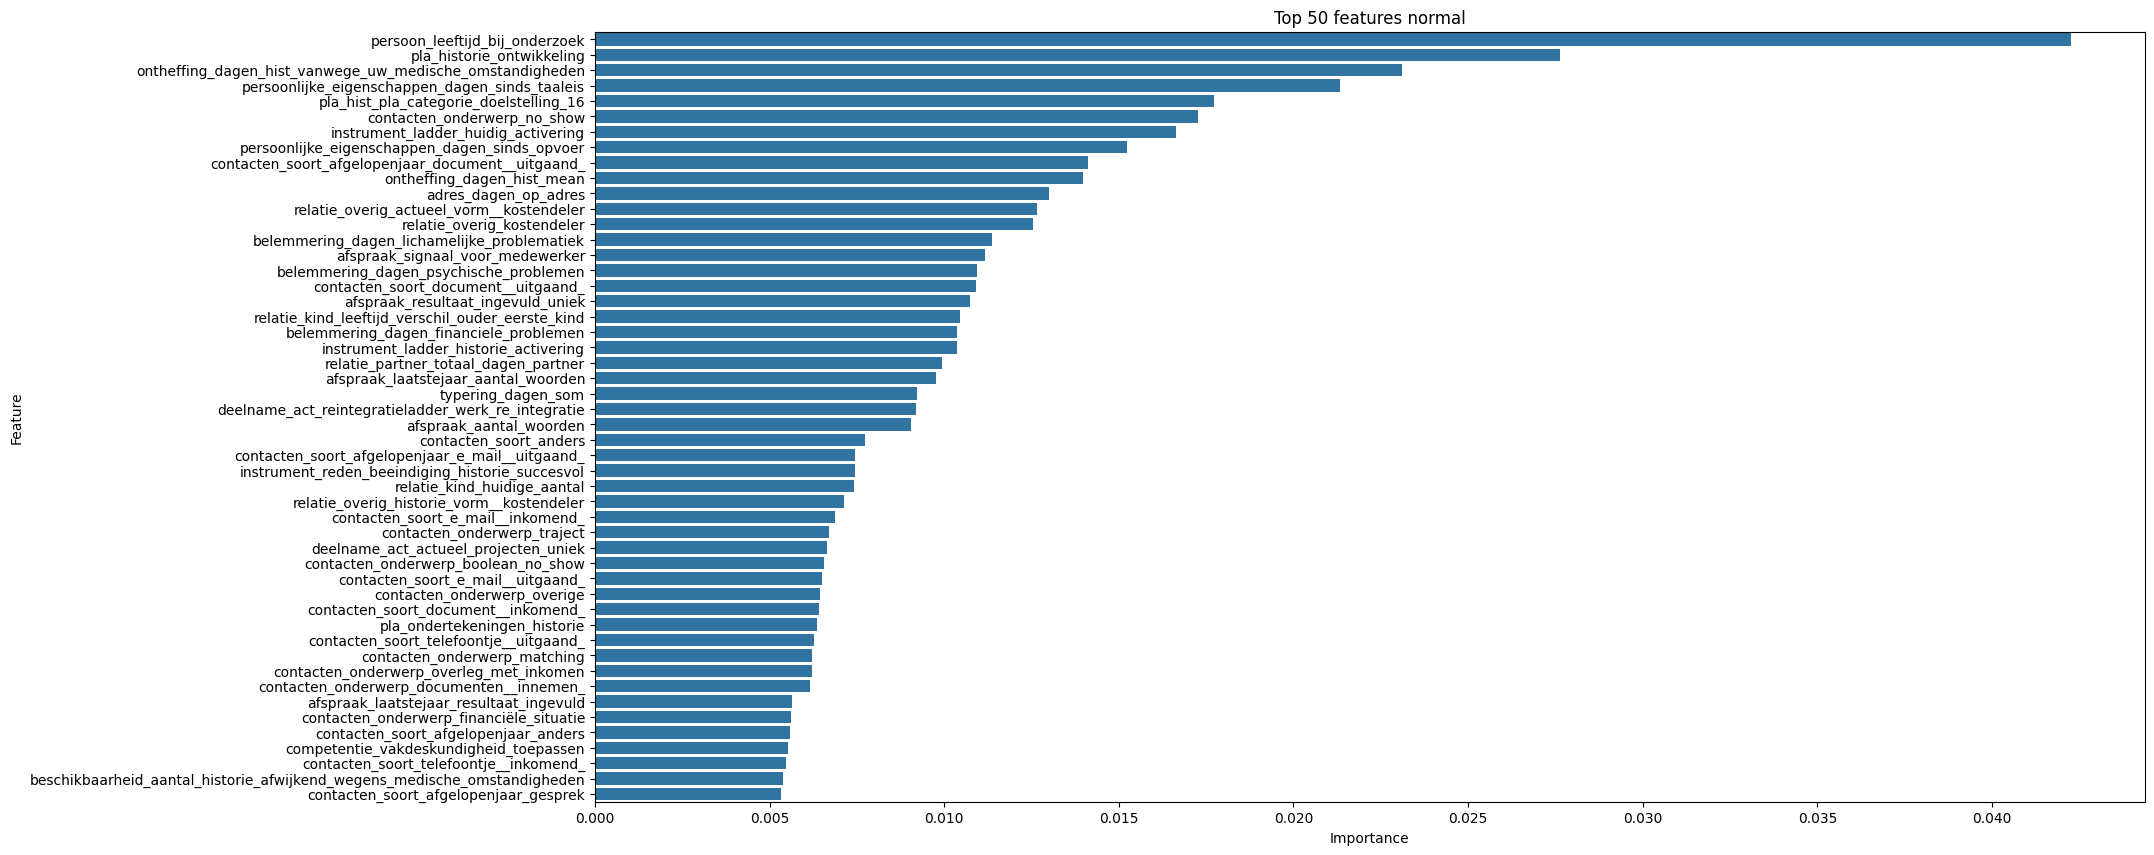

In [9]:
# TODO: Further explore feature engineering possibilities. Creating new features based on domain knowledge can provide the model with additional insights, potentially improving performance

# Initializing and training the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Getting feature importances
feature_importances = clf.feature_importances_

# Converting feature importances into a more readable format
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting features by importance
features_sorted = features.sort_values(by='Importance', ascending=False)

# Plotting the top 50 features
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=features_sorted.head(50))
plt.title('Top 50 features normal')
plt.show()

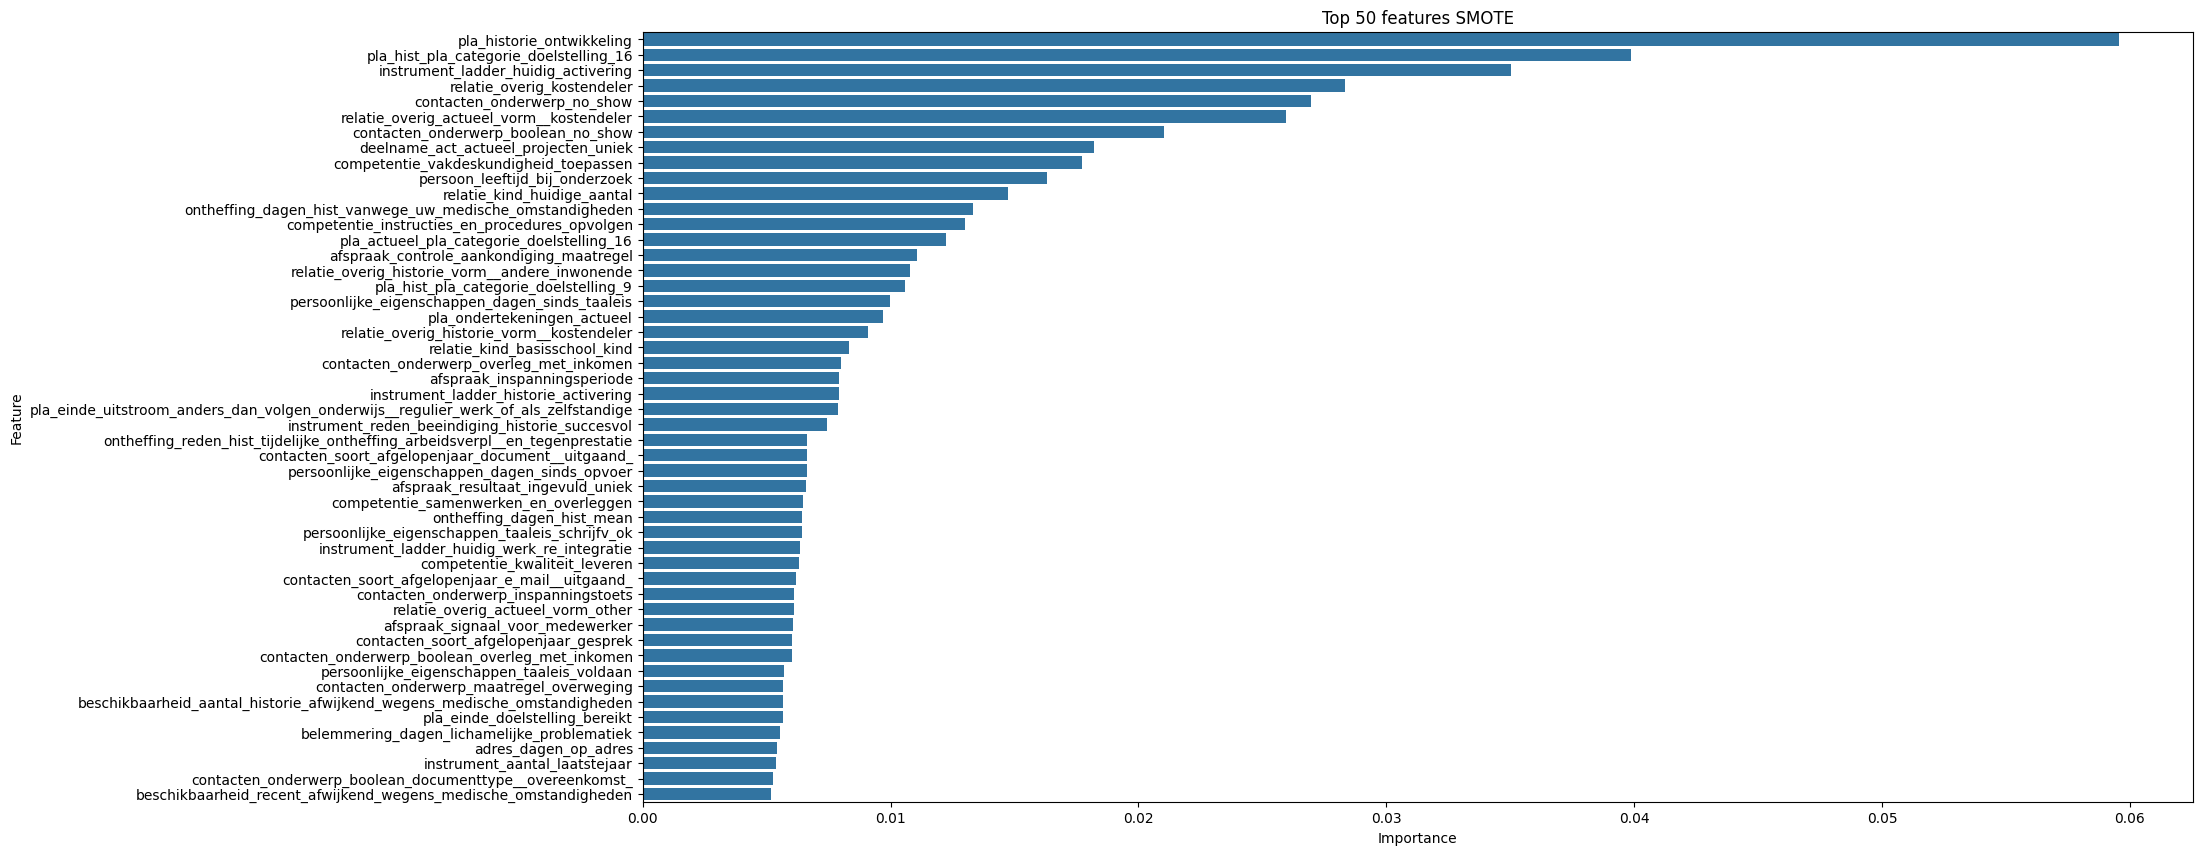

In [10]:
# TODO: Further explore feature engineering possibilities. Creating new features based on domain knowledge can provide the model with additional insights, potentially improving performance

# Initializing and training the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Getting feature importances
feature_importances = clf.feature_importances_

# Converting feature importances into a more readable format
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting features by importance
features_sorted = features.sort_values(by='Importance', ascending=False)

# Plotting the top 50 features
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=features_sorted.head(50))
plt.title('Top 50 features SMOTE')
plt.show()

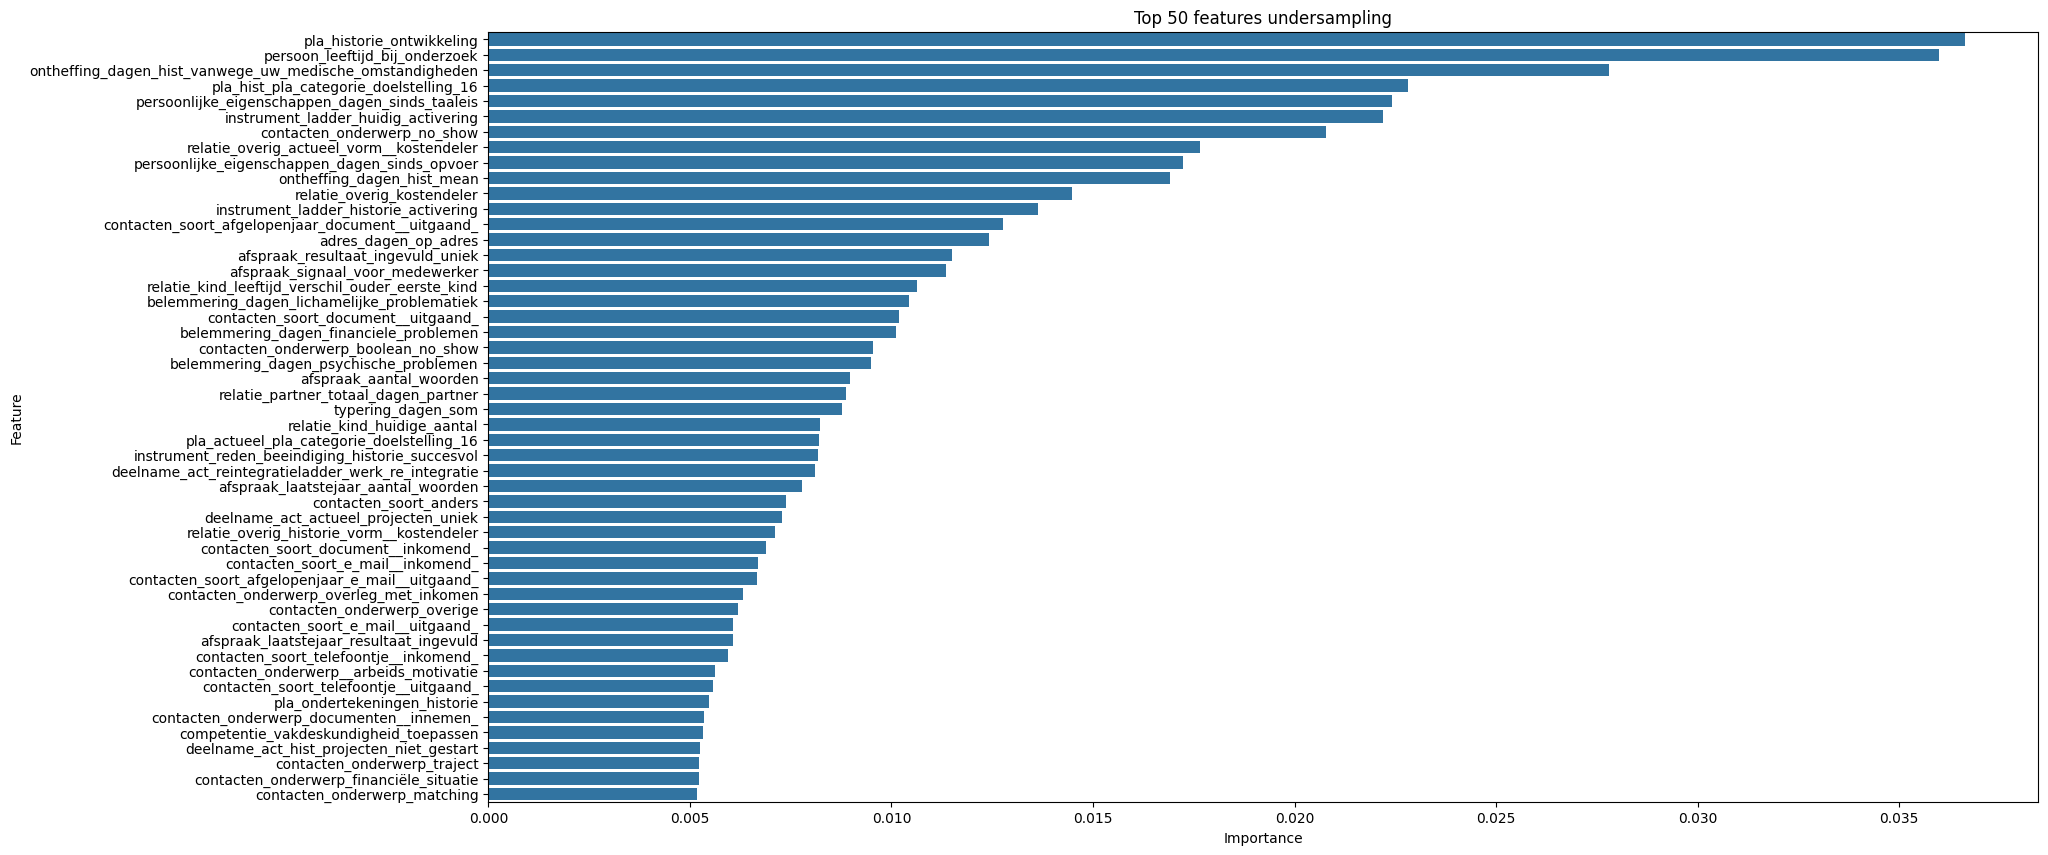

In [11]:
# TODO: Further explore feature engineering possibilities. Creating new features based on domain knowledge can provide the model with additional insights, potentially improving performance

# Initializing and training the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_under, y_train_under)

# Getting feature importances
feature_importances = clf.feature_importances_

# Converting feature importances into a more readable format
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting features by importance
features_sorted = features.sort_values(by='Importance', ascending=False)

# Plotting the top 50 features
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=features_sorted.head(50))
plt.title('Top 50 features undersampling')
plt.show()

# Feature scaling and model training

In [12]:
# Create LDA classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

adaboost = AdaBoostClassifier()

gnb = GaussianNB()

lre = LogisticRegression(
    solver='saga',
    tol=0.01,
    max_iter=200,
    random_state=0
)

lda = LinearDiscriminantAnalysis()
svc = SVC()
mlp = MLPClassifier(
    # hidden_layer_sizes=(20, 100),
    # max_iter=1000,
    # activation='relu',
    # batch_size=32,
    # solver='adam',
    # learning_rate='adaptive',
    # shuffle=True
)
rfc = RandomForestClassifier()


classifier = xgb.XGBClassifier(
    # n_estimators=100,
    # learning_rate=0.01,
    # max_depth=10,
    # subsample=0.9,
    # colsample_bytree=0.9,
    # scale_pos_weight=(len(y)-sum(y))/sum(y),  # Adjusting for imbalance
    # use_label_encoder=False,  # To avoid warning
    # eval_metric='logloss',  # Evaluation metric to avoid warning
    # random_state=0
)


In [13]:
# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
# TODO: The pipeline construction and inclusion of feature scaling via StandardScaler is a good practice, ensuring that your model is not biased by the scale of the features.
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import MinMaxScaler, RobustScaler


pipeline = Pipeline([('scaler', RobustScaler()),
                    ('regressor', classifier)])

hyperparameter_grid_xgboost = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'regressor__max_depth': [5, 10, 15],
    'regressor__subsample': [0.8, 0.9, 1],
    'regressor__colsample_bytree': [0.8, 0.9, 1],
    'regressor__scale_pos_weight': [(len(y)-sum(y))/sum(y)],
    'regressor__use_label_encoder': [False, True],
    'regressor__eval_metric': ['logloss', 'error', 'aucpr'],
}

hyperparameter_grid_mlp = {
    'regressor__hidden_layer_sizes': [(20, 100), (50, 100), (100, 100), (100, 200)],
    'regressor__max_iter': [1000, 2000, 3000],
    'regressor__activation': ['relu', 'logistic', 'tanh'],
    'regressor__batch_size': [32, 64, 128],
    'regressor__solver': ['adam', 'sgd'],
    'regressor__learning_rate': ['constant', 'adaptive'],
    'regressor__shuffle': [True, False]
}

pipeline = RandomizedSearchCV(estimator=pipeline, 
                              param_distributions=hyperparameter_grid_xgboost,
                              cv=5, n_iter=10,
                              random_state=0,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              verbose=0,
                              return_train_score=True)


# -------------------------

pipeline.fit(X_train, y_train)
y_pred1 = pipeline.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1)
recall1 = recall_score(y_test, y_pred1)
f11 = f1_score(y_test, y_pred1)
print(pipeline.best_estimator_.get_params())

# -------------------------

pipeline.fit(X_train_under, y_train_under)
y_pred2 = pipeline.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
f12 = f1_score(y_test, y_pred2)
print(pipeline.best_estimator_.get_params())

# -------------------------

pipeline.fit(X_train_smote, y_train_smote)
y_pred3 = pipeline.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred3)
precision3 = precision_score(y_test, y_pred3)
recall3 = recall_score(y_test, y_pred3)
f13 = f1_score(y_test, y_pred3)
print(pipeline.best_estimator_.get_params())

# -------------------------

print('Normal\t\t\tUnder\t\t\tOver')
print(
    f'Accuracy: {accuracy1:.4f}\tAccuracy: {accuracy2:.4f}\tAccuracy: {accuracy3:.4f}')
print(
    f'Precision: {precision1:.4f}\tPrecision: {precision2:.4f}\tPrecision: {precision3:.4f}')
print(
    f'Recall: {recall1:.4f}\t\tRecall: {recall2:.4f}\t\tRecall: {recall3:.4f}')
print(f'F1 Score: {f11:.4f}\tF1 Score: {f12:.4f}\tF1 Score: {f13:.4f}')

{'memory': None, 'steps': [('scaler', RobustScaler()), ('regressor', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...))], 'verbose': False, 'scaler': RobustScaler(), 'regressor': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode

Adjusted Accuracy: 0.9572
Adjusted Precision: 0.9510
Adjusted Recall: 0.8063
Adjusted F1 Score: 0.8727


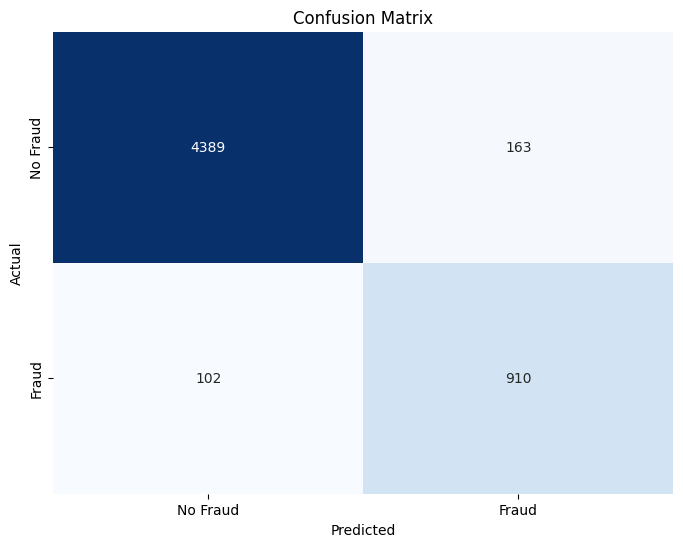

In [14]:
from sklearn.metrics import confusion_matrix


# Adjust the classification threshold
threshold = 0.9  # Set this to the new threshold you want to test
# Get the probabilities for the positive class
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_proba >= threshold).astype(
    int)  # Apply the new threshold to make predictions

# Evaluate the adjusted predictions
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)

print(f'Adjusted Accuracy: {accuracy_adjusted:.4f}')
print(f'Adjusted Precision: {precision_adjusted:.4f}')
print(f'Adjusted Recall: {recall_adjusted:.4f}')
print(f'Adjusted F1 Score: {f1_adjusted:.4f}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred3)
# conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# check for bias in the model
from aif360.datasets import BinaryLabelDataset

# Create a BinaryLabelDataset from the test data
bld = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                         label_names=['checked'],
                         protected_attribute_names=[],
                         favorable_label=1,
                         unfavorable_label=0)

# Create a BinaryLabelDataset from the predictions
bld_pred = BinaryLabelDataset(df=pd.concat([X_test, pd.Series(y_pred3, index=y_test.index)], axis=1),
                              label_names=['checked'],
                              protected_attribute_names=[],
                              favorable_label=1,
                              unfavorable_label=0)


# Compute the metrics for the original predictions
metric_orig = BinaryLabelDatasetMetric(bld, unprivileged_groups=[],
                                       privileged_groups=[])
print('Original predictions')
print('Mean difference:', metric_orig.mean_difference())
print('Disparate impact:', metric_orig.disparate_impact())
print('Statistical parity difference:', metric_orig.statistical_parity_difference())
print('Equal opportunity difference:', metric_orig.equal_opportunity_difference())
print('Average odds difference:', metric_orig.average_odds_difference())
print('Theil index:', metric_orig.theil_index())

# Compute the metrics for the predictions
metric_pred = BinaryLabelDatasetMetric(bld_pred, unprivileged_groups=[],
                                       privileged_groups=[])
print('\nPredictions')
print('Mean difference:', metric_pred.mean_difference())
print('Disparate impact:', metric_pred.disparate_impact())
print('Statistical parity difference:', metric_pred.statistical_parity_difference())
print('Equal opportunity difference:', metric_pred.equal_opportunity_difference())
print('Average odds difference:', metric_pred.average_odds_difference())
print('Theil index:', metric_pred.theil_index())



KeyError: "None of [Index(['checked'], dtype='object')] are in the [columns]"

In [ ]:
# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

MissingShapeCalculator: Unable to find a shape calculator for type '<class 'sklearn.model_selection._search.RandomizedSearchCV'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.


In [ ]:
# Let's save the model
onnx.save(onnx_model, "model/bad_model.onnx")

# Let's load the model
new_session = rt.InferenceSession("model/bad_model.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.9140893470790378
